In [ ]:
# default_exp gbe.baseline_drinking.separate

# Factor analysis
Factor analyses require large sample sizes, which this study is perfect for.

> Note: Next step is to get the scoring data per session so tasks is a session-based df. Then this df is averaged before the factor analysis, but session-level scores are used to generate factor scores.

In [ ]:
%matplotlib inline

In [ ]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext rpy2.ipython
import seaborn as sns
from matplotlib import pyplot as plt
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", font_scale = 1.3, rc=custom_params)
from IPython.core.display import HTML

In [ ]:
#export
%load_ext autoreload
%autoreload 2
from trr265.gbe.ist.data_provider import ISTDataProvider
from trr265.gbe.wm.data_provider import WMDataProvider
from trr265.gbe.sst.data_provider import SSTDataProvider
from trr265.gbe.rtt.data_provider import RTTDataProvider

import trr265.gbe.ist.scoring as ist_scoring 
import trr265.gbe.wm.scoring as wm_scoring 
import trr265.gbe.sst.scoring as sst_scoring 
import trr265.gbe.rtt.scoring as rtt_scoring 

import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the data
In this notebook, all tests and examples are run on the initial baseline dataset.

### Information sampling task

In [ ]:
# Getting raw data
dp = ISTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_ist_data(update = False)
# Adding data from redcap
df = df.merge(dp.get_gbe_data(update = True, columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
df = df.query("is_initial and is_baseline")
ist = ist_scoring.get_average_oversampling(df)#[0]
ist = ist.merge(dp.get_gbe_data(columns = ['participant']), left_on = 'gbe_index', right_index = True, how = 'left')
ist = ist.groupby('participant').mean()
ist.columns = ['ist_oversampling']

Preparing gbe_data
0.0
0.0
214 participants had unplanned sessions.  444 sessions (10.11%) were removed.
0.0


### Working memory task

In [ ]:
# Getting raw data
dp = WMDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_wm_data(update = False)
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
df = df.query("is_initial and is_baseline")
# Filtering participants with old app
df = dp.filter_old_app_sessions(df)
df = dp.filter_level_two_failures(df)
wm = wm_scoring.get_max_levels(df)
wm = wm.merge(dp.get_gbe_data(columns = ['participant']), left_on = 'gbe_index', right_index = True, how = 'left')
wm = wm.groupby('participant').mean()
wm = wm.rename(columns={'max_level_no_distractor_1': 'wm_no_1',
                        'max_level_no_distractor_2': 'wm_no_2',
                        'max_level_encoding_distractor': 'wm_encoding',
                        'max_level_delayed_distractor':'wm_delayed'})

8 participants used an old version of the task in some of their sessions.  13 sessions (2.48%) were removed from the dataset.
6 sessions (1.17%) were removed because participants failed a level two trial.


### Risk taking task

In [ ]:
# Getting raw data
dp = RTTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_rtt_data(update = False)
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
df = df.query("is_initial and is_baseline")
rtt = rtt_scoring.get_percentage_gamble(df)
rtt = rtt.merge(dp.get_gbe_data(columns = ['participant']), left_on = 'gbe_index', right_index = True, how = 'left')
rtt = rtt.groupby('participant').mean()
rtt = rtt.rename(columns={'perc_gamble_win': 'rtt_win',
                       'perc_gamble_loss': 'rtt_loss',
                       'perc_gamble_mixed': 'rtt_mixed'})

### Stop signal task

In [ ]:
# Getting raw data
dp = SSTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_sst_data(update = False)
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
df = df.query("is_initial and is_baseline")
sst = sst_scoring.get_integration_without_replacement_ssrts(df)
sst = sst.merge(dp.get_gbe_data(columns = ['participant']), left_on = 'gbe_index', right_index = True, how = 'left')
sst = sst.groupby('participant').mean()
sst.columns = ['ssrt']

## Factor analysis
Using oblimin rotation similar to Eisenberg.

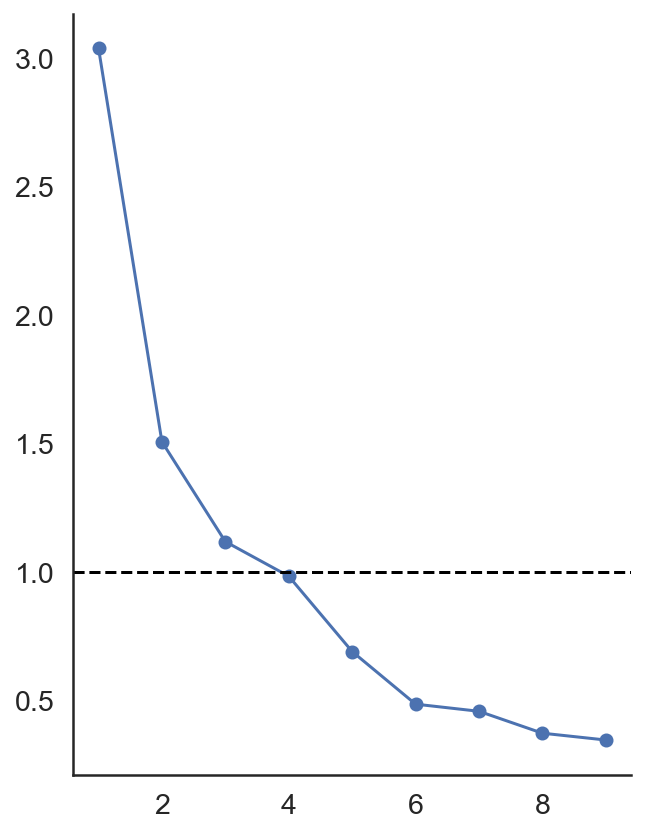

0.7511959295974905


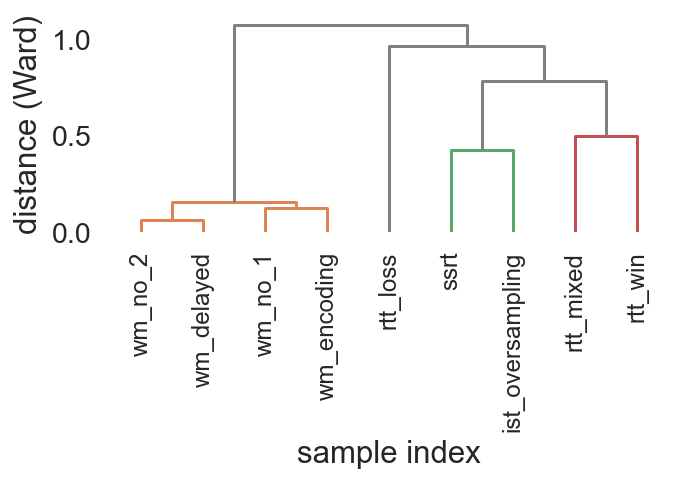

<AxesSubplot:>

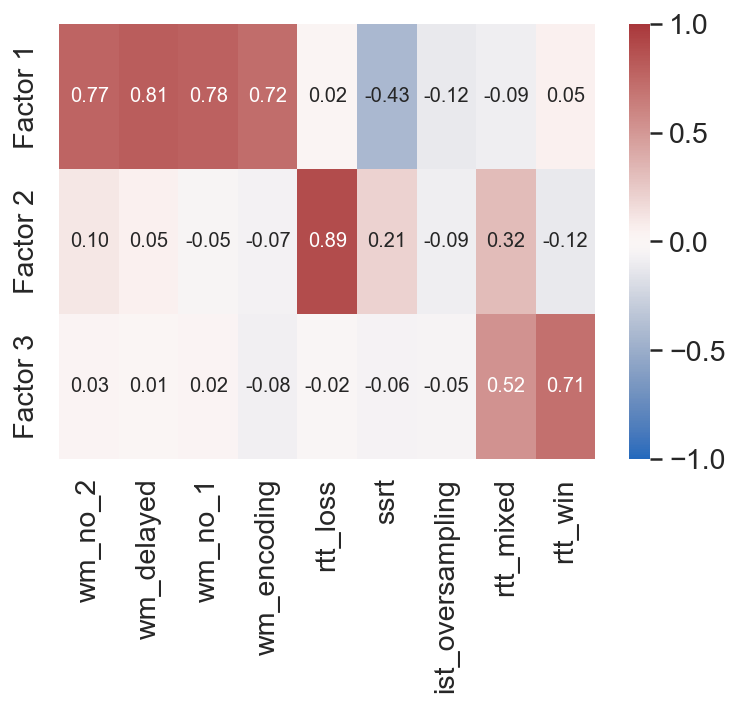

In [ ]:
from factor_analyzer.factor_analyzer import calculate_kmo # The factor_analyzer package is based on the R psych package
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer import FactorAnalyzer

from scipy.spatial.distance import pdist
import numpy as np
from scipy.cluster.hierarchy import linkage
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

def check_factor_analysis(df):
    # Testing suitability for factor analysis
    chi_square_value,p_value=calculate_bartlett_sphericity(df)
    kmo_all,kmo_model=calculate_kmo(df)
    bartletts_passed = "passes" if p_value < .05 else "failed"
    display(HTML("Bartlett's test %s: chi_square = %.2f; p = %.2e; Kaiser-Meyer-Olkin test: %.3f (ideally should be above .8)."%(bartletts_passed, chi_square_value, p_value,kmo_model)))
    
    
def scree_plot(df, rotation = 'oblimin'):
    fa = FactorAnalyzer(rotation=rotation)
    fa.fit(df)
    ev, v = fa.get_eigenvalues()
    fig, axes = plt.subplots(1, 1, figsize=(5, 7))
    plt.scatter(range(1, df.shape[1]+1),ev)
    ax = plt.plot(range(1, df.shape[1]+1),ev)
    plt.axhline(1, color = 'black', linestyle = '--')
    plt.show()
    
def factor_analysis(df, n_factors, rotation = 'oblimin'):
    fa = FactorAnalyzer(rotation=rotation, n_factors = n_factors)
    fa.fit(df)
    return fa

def get_factor_loadings(fa, df):
     return pd.DataFrame(fa.loadings_, columns = ["Factor %d"%i for i in range(1, fa.n_factors+1)], index = df.columns)
    
def dendogram(df, distances = 'euclidean'):
    #d = np.transpose(np.arange(1,10001).reshape(100,100))
    d = df.values
    distances = pdist(d, distances) #euclidean
    link = linkage(distances, "average")
    default_color_threshold = 0.7*np.max(link[:,2])
    print(default_color_threshold)
    fig, axes = plt.subplots(1, 1, figsize=(5, 2))
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    plt.xlabel('sample index')
    plt.ylabel('distance (Ward)')
    dendo = dendrogram(link, labels=df.index, leaf_rotation=90,color_threshold=default_color_threshold, above_threshold_color= 'grey')
    plt.show()
    return dendo
    
def factor_loading_heatmap(factor_loadings,column_order):
    return sns.heatmap(factor_loadings.T[column_order], annot=True, center = 0, vmin=-1, vmax=1, cmap = sns.color_palette("vlag", as_cmap=True), fmt=".2f", annot_kws={'size': 10})


# Calculating factors based on average session scores   
tasks = pd.concat([wm.groupby('participant').mean(), 
                   sst.groupby('participant').mean(), # Note that we reversed the SST data
                   rtt.groupby('participant').mean(),
                   ist.groupby('participant').mean()],axis = 1).dropna()#.drop(columns='session_number')

check_factor_analysis(tasks)
scree_plot(tasks, rotation = 'oblimin')
fa = factor_analysis(tasks, 3, rotation = 'oblimin')
factor_loadings = get_factor_loadings(fa, tasks)
dendo = dendogram(factor_loadings)
factor_loading_heatmap(factor_loadings, dendo['ivl'])


#### A four factor solution

In [ ]:
check_factor_analysis(tasks)
scree_plot(tasks, rotation = 'oblimin')
fa4 = factor_analysis(tasks, 4, rotation = 'oblimin')
factor_loadings4 = get_factor_loadings(fa4, tasks)
factor_loadings4
dendo = dendogram(factor_loadings4)
factor_loading_heatmap(factor_loadings4, dendo['ivl'])

### Factor scores
Factor scores calculated via the ten Berge method (for oblim rotation; Eisenberg; https://www.sciencedirect.com/science/article/pii/S0024379597100076; https://stackoverflow.com/questions/67856186/correct-way-to-calculate-correlations-between-factors).

In [ ]:
import warnings
import numpy as np
from sklearn.preprocessing import scale

def matrix_sqrt(x):
    """
    Compute the square root of the eigen values (eVal),
    and then take $eVec * diag(eVals^0.5) * eVec^T$
    """
    evals, evecs = np.linalg.eig(x)
    evals[evals < 0] = np.finfo(float).eps
    sqrt_evals = np.sqrt(evals)
    return evecs.dot(np.diag(sqrt_evals)).dot(evecs.T)


def inv_matrix_sqrt(x):
    """
    Compute the inverse square root of the eigen values (eVal),
    and then take $eVec * diag(1 / eVals^0.5) * eVec^T$
    """
    evals, evecs = np.linalg.eig(x)
    if np.iscomplex(evals).any():
        warnings.warn('Complex eigen values detected; results are suspect.')
        return x
    evals[evals < np.finfo(float).eps] = 100 * np.finfo(float).eps
    inv_sqrt_evals =  1 / np.sqrt(evals)
    return evecs.dot(np.diag(inv_sqrt_evals)).dot(evecs.T)


def ten_berge(X, loadings, phi=None):
    """
    Estimate factor scores using the "ten Berge" method.

    Parameters
    ----------
    X : array-like
        The data set
    loadings : array-like
        The loadings matrix

    Reference
    ----------
    https://www.sciencedirect.com/science/article/pii/S0024379597100076
    """
    # get the number of factors from the loadings
    n_factors = loadings.shape[1]
    corr = np.corrcoef(X, rowvar=False)
    # if `phi` is None, create a diagonal matrix
    phi = np.diag(np.ones(n_factors)) if phi is None else phi
    # calculate intermediate metrics
    load = loadings.dot(matrix_sqrt(phi))
    corr_inv = inv_matrix_sqrt(corr)
    temp = corr_inv.dot(load)\
                   .dot(inv_matrix_sqrt(load.T.dot(np.linalg.inv(corr))
                                              .dot(load)))
    # calcualte weights
    weights = corr_inv.dot(temp)\
                      .dot(matrix_sqrt(phi))
    # calculate scores, given weights
    scores = scale(X).dot(weights)
    return scores

In [ ]:
tasks_session = pd.concat([wm, sst,rtt, ist],axis = 1).dropna()
tasks_session = tasks_session.loc[:,~tasks_session.columns.duplicated()]
tasks_session = tasks_session.set_index(['participant','session_number'])

KeyError: "None of ['participant', 'session_number'] are in the columns"

In [ ]:
factor_scores = pd.DataFrame(ten_berge(tasks, fa.loadings_))
factor_scores.columns = ['Factor 1','Factor 2','Factor 3']
factor_scores = pd.concat([tasks.reset_index(),factor_scores],axis = 1)

In [ ]:
factor_scores.set_index(['participant']).corr()

,wm_no_1,wm_no_2,wm_encoding,wm_delayed,ssrt,rtt_loss,rtt_mixed,rtt_win,ist_oversampling,Factor 1,Factor 2,Factor 3
wm_no_1,1.000000,0.611623,0.572034,0.617888,-0.341704,-0.061786,-0.082469,0.091585,-0.125575,8.441491e-01,-7.025054e-02,4.087158e-02
wm_no_2,0.611623,1.000000,0.530841,0.643017,-0.296435,0.067290,-0.005579,0.075805,-0.060291,8.287281e-01,9.508192e-02,4.984994e-02
wm_encoding,0.572034,0.530841,1.000000,0.572910,-0.339417,-0.076593,-0.147337,0.017162,-0.082848,7.745594e-01,-9.799250e-02,-9.570398e-02
wm_delayed,0.617888,0.643017,0.572910,1.000000,-0.355799,0.015404,-0.016213,0.054044,-0.067855,8.671241e-01,3.652719e-02,2.918331e-02
ssrt,-0.341704,-0.296435,-0.339417,-0.355799,1.000000,0.192751,0.091586,-0.088275,0.092795,-4.636841e-01,2.406882e-01,-7.057913e-02
rtt_loss,-0.061786,0.067290,-0.076593,0.015404,0.192751,1.000000,0.327158,-0.048466,-0.111942,-9.084087e-04,9.912115e-01,1.830901e-02
rtt_mixed,-0.082469,-0.005579,-0.147337,-0.016213,0.091586,0.327158,1.000000,0.344152,-0.031460,-9.449487e-02,3.804351e-01,6.886489e-01
rtt_win,0.091585,0.075805,0.017162,0.054044,-0.088275,-0.048466,0.344152,1.000000,-0.055711,6.738592e-02,-1.076715e-01,9.082135e-01
ist_oversampling,-0.125575,-0.060291,-0.082848,-0.067855,0.092795,-0.111942,-0.031460,-0.055711,1.000000,-1.298651e-01,-9.806859e-02,-7.217819e-02
Factor 1,0.844149,0.828728,0.774559,0.867124,-0.463684,-0.000908,-0.094495,0.067386,-0.129865,1.000000e+00,1.649651e-15,1.231460e-16


### Factor score correlation with drinking

In [ ]:
initial_participants = dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']).query("is_initial").participant.unique()
ba = dp.get_ba_data(columns = ['redcap_event_name','mov_id','bx_aud_sum']).query("redcap_event_name=='erhebungszeitpunkt_arm_1'")
ba = ba[ba.mov_id.isin(initial_participants)]
aud = ba[~ba.bx_aud_sum.isnull()][['mov_id','bx_aud_sum']]
aud.columns = ['participant','aud']
aud = aud.groupby('participant').first()
standard_last_three = dp.get_baseline_drinking_data().loc[initial_participants]
two_day = dp.get_two_day_data()
drinking_days = two_day.query("sampling_day<30")#.groupby('participant').g_alc.agg(['mean','median'])
drinking_days['drinking_days'] = drinking_days.g_alc>0
drinking_days = drinking_days.groupby('participant')[['g_alc','drinking_days']].sum().reset_index()
drinking_days = drinking_days[drinking_days.participant.isin(initial_participants)].set_index('participant')
drinking_days['g_alc_per_drinking_day'] = drinking_days.g_alc / drinking_days.drinking_days
drinking_days.replace([np.inf, -np.inf], np.nan).isna().sum()
drinking_days = drinking_days[['drinking_days','g_alc_per_drinking_day']]
two_day = dp.get_two_day_data()
average_ema = two_day.query("sampling_day<30").groupby('participant').g_alc.agg(['mean','median'])
average_ema.columns = ['mean_g_alc','median_g_alc']
average_ema = average_ema.reset_index()
average_ema = average_ema[average_ema.participant.isin(initial_participants)].set_index('participant')
standard_last_three['g_alc_per_drinking_day_last_three_month'] = standard_last_three.drinks_per_drinking_day_last_three_month * 12
standard_last_three['g_alc_per_day_last_three_month'] = standard_last_three.last_three_month * 12
drinking = pd.concat([standard_last_three[['g_alc_per_day_last_three_month','drinking_days_last_three_month','g_alc_per_drinking_day_last_three_month']], aud, average_ema, drinking_days],axis = 1)


In [ ]:
pp_factor_scores = factor_scores.groupby('participant').mean().filter(like='Factor')
pp_factor_scores

,Factor 1,Factor 2,Factor 3
participant,,,
b001,0.588140,-0.498889,0.042701
b002,1.060368,1.110831,1.625678
b012,0.564953,1.445790,0.908372
b013,-3.419652,-0.207975,-0.597663
b015,0.706052,1.567812,0.382403
...,...,...,...
m202,0.451300,-0.396055,0.188850
m205,-3.516468,-1.572243,1.650586
m235,0.615192,-0.563763,0.848762


In [ ]:
result = pd.concat([pp_factor_scores, drinking], axis=1, join="inner").dropna()

In [ ]:
import numpy as np
import trr265.stats as stats
import scipy.stats


def correl(df, corr_func = scipy.stats.pearsonr):
    df_corr = pd.DataFrame() # Correlation matrix
    
    df_p = pd.DataFrame()  # Matrix of p-values
    for x in df.columns:
        for y in df.columns:
            corr = corr_func(df[x], df[y])
            df_corr.loc[x,y] = corr[0]
            df_p.loc[x,y] = corr[1]
    return df_corr, df_p

def correlation_matrix(analysis_data, alpha = .05, bonferroni = False, size = (11,9), show_correl = True, corr_func = scipy.stats.pearsonr):
    print(len(analysis_data))

    if bonferroni:
        variables = len(analysis_data.columns)
        correction = ((variables * variables) - variables)/2
        alpha = alpha / correction

    df_corr, df_p = correl(analysis_data, corr_func = corr_func)
    sig = (df_p < alpha).replace({True:"*",False:""})
    # Generate a mask for the upper triangle
    mask = np.zeros_like(df_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    df_corr_label = df_corr.applymap(lambda x: '%.2f'%x)
    df_corr_label = df_corr_label + sig
    if show_correl:
        p1 = sns.heatmap(df_corr, mask=mask,cmap=cmap, center=0, vmax=1, vmin=-1,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},
                   annot=df_corr_label,fmt = '')
    else:
         p1 = sns.heatmap(df_corr, mask=mask,cmap=cmap, center=0, vmax=1, vmin=-1,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},fmt = '')       
    p1.text(len(df_corr)-1, 1, "Alpha = %g"%alpha, size='medium', color='black')
    p = df_p.unstack()
    p.index = ['*'.join(map(str,i)) for i in p.index.tolist()]
    p = p.to_dict()
    corr = df_corr.unstack()
    corr.index = ['*'.join(map(str,i)) for i in corr.index.tolist()]
    corr = corr.to_dict()

247


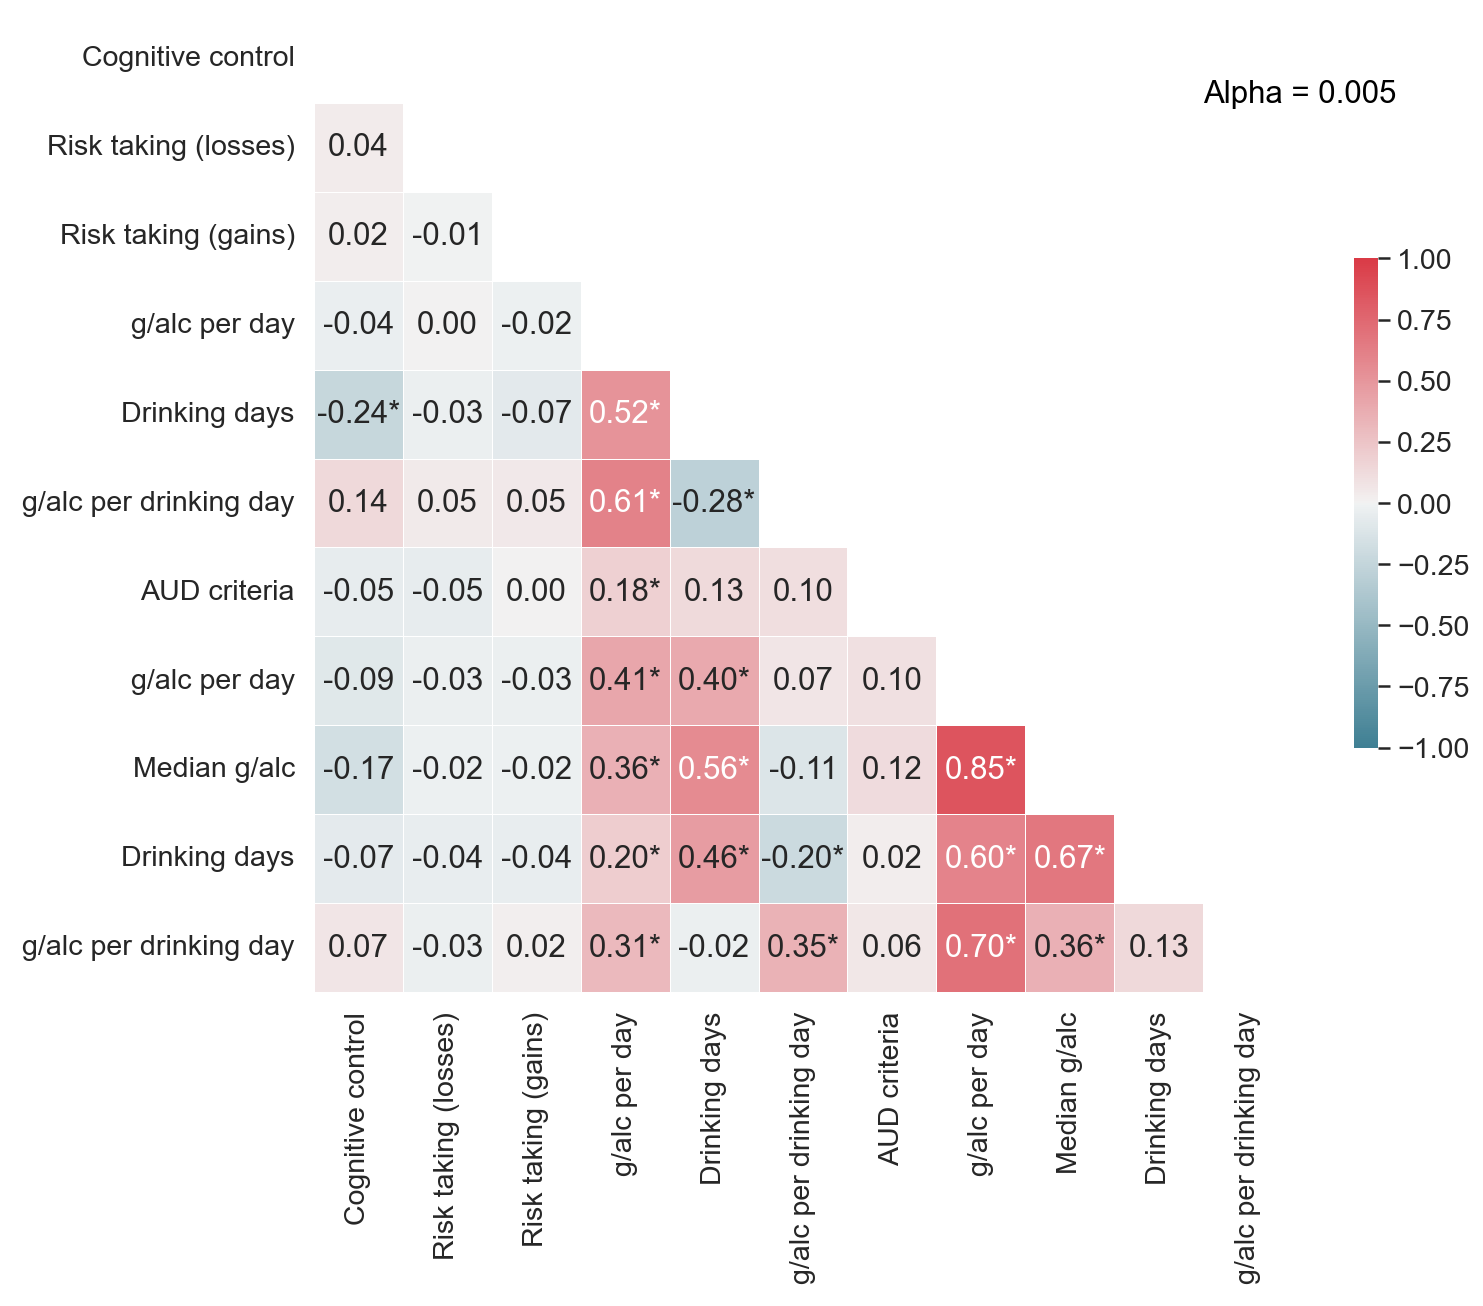

In [ ]:
labels = {
    "wm_no_1":"no distractor (long)",
    "wm_no_2":"no distractor (short)",
    "wm_encoding":"encoding distractor",
    "wm_delayed":"delayed distractor",
    "rtt_win":"% gambles (win)",
    "rtt_loss":"% gambles (loss)",
    "rtt_mixed":"% gambles (mixed)",
    "ist_oversampling":"oversampling",
    "last_three_month":"Drinks per day",
    "g_alc_per_day_last_three_month":"g/alc per day",
    "g_alc_per_drinking_day_last_three_month":"g/alc per drinking day",
    "drinking_days_last_three_month":"Drinking days",
    "drinks_per_drinking_day_last_three_month":"Drinks per drinking day",
    "aud":"AUD criteria",
    "mean_g_alc":" g/alc per day",
    "median_g_alc":"Median g/alc",
    "drinking_days":" Drinking days",
    "g_alc_per_drinking_day":" g/alc per drinking day",
    "Factor 1": "Cognitive control",
    "Factor 2": "Risk taking (losses)",
    "Factor 3": "Risk taking (gains)"
}
result = result.rename(columns = labels) 
correlation_matrix(result.drop('b138'),corr_func = scipy.stats.spearmanr, alpha = .005) # dropping one participant who does not have joint scores

In [ ]:
from scipy.stats import spearmanr

In [ ]:
spearmanr(result.drop('b138')['Cognitive control'], result.drop('b138')['Drinking days'])

SpearmanrResult(correlation=-0.23505329537469236, pvalue=0.00019317642707393327)

In [ ]:
spearmanr(result.drop('b138')['Cognitive control'], result.drop('b138')['Median g/alc'])

SpearmanrResult(correlation=-0.16569719506700226, pvalue=0.00908110406095342)

### Cognitive control correlations

In [ ]:
stats.pearsonr(result['Cognitive control'], result['Drinking days'])

In [ ]:
plt.figure(figsize=(10,6))

sns.regplot(x = 'Cognitive control', y = 'Drinking days', data=result, scatter_kws={'s':12})

In [ ]:
stats.pearsonr(result['Cognitive control'], result['Median g/alc'])

In [ ]:
plt.figure(figsize=(10,6))

sns.regplot(x = 'Cognitive control', y = 'Median g/alc', data=result, scatter_kws={'s':12})

In [ ]:
correlation_matrix(result, corr_func = scipy.stats.spearmanr, alpha = .005)

## Model based RTT scores

In [ ]:
rtt_columns = 'PT_alphaL, PT_alphaG, PT_lambda, PT_mu, AA_alphaL, AA_alphaG, AA_lambda, AA_pavL, AA_pavG, AA_mu'.split(', ')

In [ ]:
rtt_data_md = pd.read_pickle('../data/interim/rtt_data_md.pkl').query('sess<3').groupby('mov_id').mean()[rtt_columns]

In [ ]:
#rtt_data_md.query('sess<3').groupby()
rtt_data_md

In [ ]:
merged = tasks.drop(columns = ['rtt_win','rtt_loss','rtt_mixed']).merge(rtt_data_md, left_index = True, right_index = True, validate = 'one_to_one')

In [ ]:
check_factor_analysis(merged)
scree_plot(merged, rotation = 'oblimin')
fa = factor_analysis(merged, 3, rotation = 'oblimin')
factor_loadings = get_factor_loadings(fa, merged)
dendo = dendogram(factor_loadings)
factor_loading_heatmap(factor_loadings, dendo['ivl'])